In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [2]:
import pylake

C:\Users\leroquan\AppData\Local\anaconda3\envs\mitgcm_env\lib\site-packages\pylake\pylake.py:3: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [3]:
from alplakes import parse_alplakes_1d_from_directory

## Import cropped netcdf MITgcm results

In [4]:
mitgcm_paths = [r"D:\geneva_lw_simstrat\lexplore_depth_time_merged.nc",
                r"D:\geneva_lw_corr\crop_results\lexplore_depth_time.nc"]

mitgcm_labels = ["MITgcm cloud simstrat",
                 "MITgcm lw corr"]

In [5]:
xr_mitgcm = []
for i in range(len(mitgcm_paths)):
    xr_mitgcm.append(xr.open_dataset(mitgcm_paths[i]))

In [19]:
start_date = pd.to_datetime(xr_mitgcm[1]['time'].values[0]).to_pydatetime()  #datetime(2024, 1, 1, 0, 0, 0)
end_date = pd.to_datetime(xr_mitgcm[1]['time'].values[-1]).to_pydatetime() #datetime(2025, 1, 1, 0, 0, 0)

## Import simstrat

In [20]:
folder_path = '../../data/alplakes_1d/geneva/'  # Update this to your specific folder path
simstrat_data = parse_alplakes_1d_from_directory(folder_path)

In [21]:
simstrat_data = simstrat_data.assign_coords(depth= -1*simstrat_data['depth'].values)

## Import measure

In [22]:
xr_measure = xr.open_dataset(f'../../data/datalakes/geneva_idronaut/2024.nc')

## Interpolate on same timestep

In [23]:
def interpolate_to_axis(xr_ds, axis, axis_name, max_gap=None):
    interp_ds = xr_ds.interp({axis_name: axis})

    if max_gap is not None:
        nearest_values = xr_ds[axis_name].sel({axis_name: axis}, method="nearest")
        diff = abs(nearest_values - axis)
        invalid_axis = axis[np.array(diff <= max_gap)]
        mask = interp_ds[axis_name].isin(invalid_axis)
        interp_ds = interp_ds.where(mask, np.nan)
    
    return interp_ds

In [24]:
def resample_all_timeseries(time_step, max_time_gap_allowed):    
    common_time_axis = pd.date_range(
        start=pd.Timestamp(start_date).normalize(), 
        end=pd.Timestamp(end_date), 
        freq=time_step
    )
    common_depth_axis = np.arange(0, -61, -1)
    
    meas_selected = xr_measure['temp']
    meas_interp_time = interpolate_to_axis(meas_selected, common_time_axis, 'time', max_time_gap_allowed)
    meas_interp = interpolate_to_axis(meas_interp_time, common_depth_axis, 'depth')
    
    mitgcm_interp = []
    for i in range(len(xr_mitgcm)):
        mitgcm_selected=xr_mitgcm[i]['THETA']
        mitgcm_interp_time = interpolate_to_axis(mitgcm_selected, common_time_axis, 'time', max_time_gap_allowed)
        mitgcm_interp.append(interpolate_to_axis(mitgcm_interp_time, common_depth_axis, 'Z'))
    
    simstrat_selected = simstrat_data['temperature']
    simstrat_interp_time = interpolate_to_axis(simstrat_selected, common_time_axis, 'time', max_time_gap_allowed)
    simstrat_interp = interpolate_to_axis(simstrat_interp_time, common_depth_axis, 'depth')
    
    return meas_interp, mitgcm_interp, simstrat_interp

In [25]:
time_step = '3h'
depth_plot=-1 # Value should be negative !!
max_time_gap_allowed = np.timedelta64(3, 'h') 

meas_interp, mitgcm_interp, simstrat_interp = resample_all_timeseries(time_step, max_time_gap_allowed)

## Compute differences

In [26]:
%matplotlib notebook
plt.close('all')
fig, ax = plt.subplots(1,1,figsize=(10, 7))

mitgcm_interp[0].rename({'Z':'depth'}).plot(x='time')
plt.title('MITgcm error [°C]')
plt.ylabel('Depth [m]')
plt.show()

<IPython.core.display.Javascript object>

# Heat content

In [27]:
temp_meas = meas_interp.values
depth = meas_interp.depth.values
bthA = np.ones(61)
bthD = depth

In [28]:
heat_content_meas = pylake.heat_content(temp_meas, bthA=bthA, bthD=bthD, depth=depth, s=0.2)

In [29]:
heat_content_mitgcm = []
for i in range(len(mitgcm_interp)):
    heat_content_mitgcm.append(pylake.heat_content(mitgcm_interp[i].values, bthA=bthA, bthD=bthD, depth=depth, s=0.2))

In [30]:
heat_content_simstrat = pylake.heat_content(simstrat_interp.values, bthA=bthA, bthD=bthD, depth=depth, s=0.2)

In [31]:
heat_content_meas = heat_content_meas.assign_coords(time=meas_interp['time'])
heat_content_simstrat = heat_content_simstrat.assign_coords(time=meas_interp['time'])

for i in range(len(heat_content_mitgcm)):
    heat_content_mitgcm[i] = heat_content_mitgcm[i].assign_coords(time=meas_interp['time'])

In [32]:
heat_content_meas = heat_content_meas.where(heat_content_meas > 0, np.nan)
heat_content_simstrat = heat_content_simstrat.where(heat_content_simstrat > 0, np.nan)

for i in range(len(heat_content_mitgcm)):
    heat_content_mitgcm[i] = heat_content_mitgcm[i].where(heat_content_mitgcm[i] > 0, np.nan)

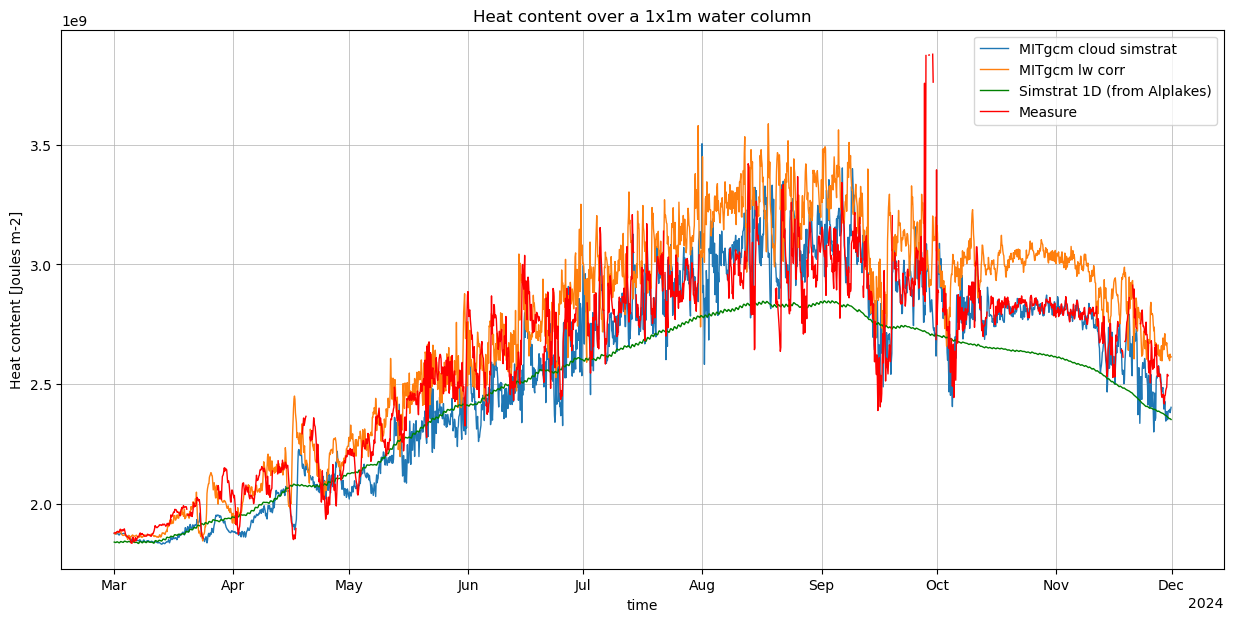

In [33]:
%matplotlib inline
plt.close('all')
plt.subplots(1,1,figsize=(15, 7))

for i in range(len(heat_content_mitgcm)):
    heat_content_mitgcm[i].plot(label=mitgcm_labels[i], lw=1)
heat_content_simstrat.plot(label='Simstrat 1D (from Alplakes)', color='green', lw=1)
heat_content_meas.plot(label='Measure', color='red', lw=1)

plt.title('Heat content over a 1x1m water column')
plt.ylabel('Heat content [Joules m-2]')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

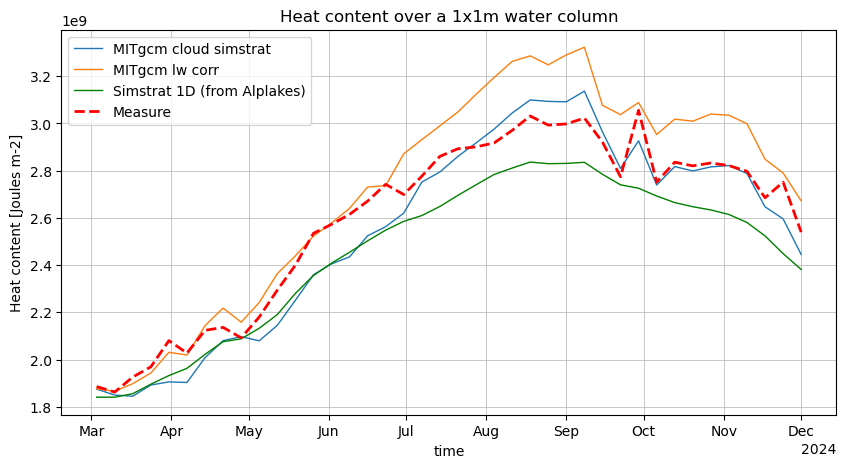

In [34]:
%matplotlib inline
plt.close('all')
plt.subplots(1,1,figsize=(10, 5))

for i in range(len(heat_content_mitgcm)):
    heat_content_mitgcm[i].resample(time='W').mean().plot(label=mitgcm_labels[i], lw=1)

heat_content_simstrat.resample(time='W').mean().plot(label='Simstrat 1D (from Alplakes)', color='green', lw=1)
heat_content_meas.resample(time='W').mean().plot(label='Measure', color='red', lw=2, linestyle='--')

plt.title('Heat content over a 1x1m water column')
plt.ylabel('Heat content [Joules m-2]')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

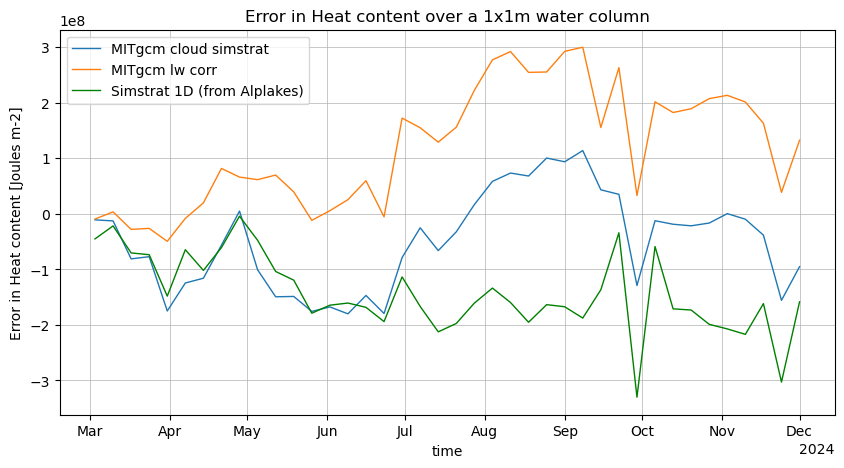

In [35]:
%matplotlib inline
plt.close('all')
plt.subplots(1,1,figsize=(10, 5))

# Resample to monthly averages
for i in range(len(heat_content_mitgcm)):
    (heat_content_mitgcm[i].resample(time='W').mean() - heat_content_meas.resample(time='W').mean()).plot(label=mitgcm_labels[i], lw=1)
(heat_content_simstrat.resample(time='W').mean() - heat_content_meas.resample(time='W').mean()).plot(label='Simstrat 1D (from Alplakes)', color='green', lw=1)

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.title('Error in Heat content over a 1x1m water column')
plt.ylabel('Error in Heat content [Joules m-2]')
plt.show()

# Heat content map

In [26]:
heat_content_map = xr.open_dataset(r"D:\geneva_lw_corr\crop_results\heat_content_map.nc")

In [27]:
heat_content_map_crop=heat_content_map.where(heat_content_map > 0)

In [28]:
import matplotlib
matplotlib.use('Agg') 

In [29]:
def plot_map(i_time):    
    plt.close('all')
    fig, ax = plt.subplots(figsize=(10, 5))
    heat_plot = heat_content_map_crop.__xarray_dataarray_variable__.isel(time=i_time).plot(ax=ax, vmin=3e9, vmax=3.4e9)
    ax.scatter(49850, 18100, marker='x', color='red')
    
    heat_plot.colorbar.set_label('Heat content [Joules m$^{-2}$]')
    plt.title(f'Heat content over the first 60m, {heat_content_map_crop.time.isel(time=i_time).values.astype(str)[:16]}')
    plt.savefig(fr'./output/heat_map_{i_time}.png')
    plt.close(fig)

In [30]:
for i in range(3000, 4500):
    plot_map(i)